<a href="https://colab.research.google.com/github/lucaskydelima/Optimization-with-Python-Pyomo/blob/main/S3Example3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyomo
! apt-get install -y -qq glpk-utils

In [2]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

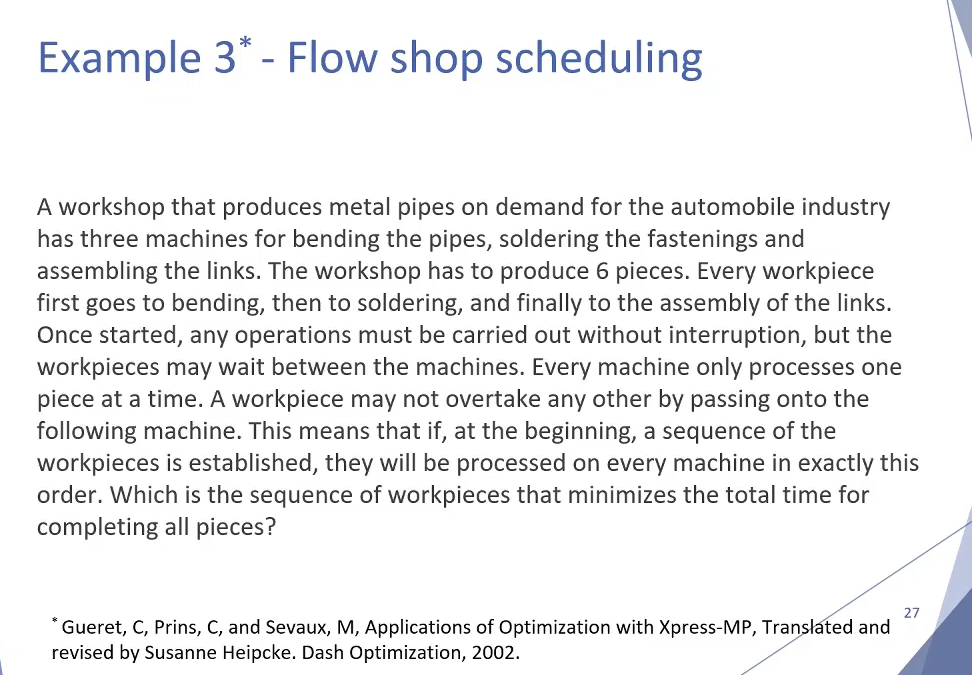

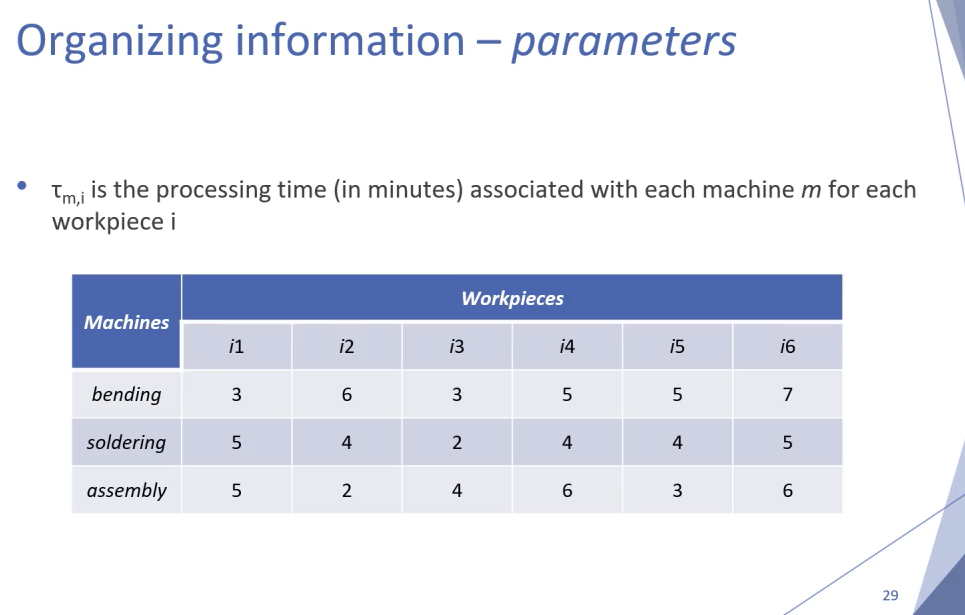

In [14]:
# Defining the model

model = pyo.ConcreteModel()

# Sets
model.i = pyo.RangeSet(1,6)
model.m = pyo.Set(initialize=('bending', 'soldering', 'assembly'))

# Creating an alias set for i - used for ranking of the jobs in i
model.k = pyo.Set(initialize=model.i) 

# Params
model.tau = pyo.Param(model.m, initialize=
                      {'bending': {1:3, 2:6, 3:3, 4:5, 5:5, 6:7},
                       'soldering':{1:5, 2:4, 3:2, 4:4, 5:4, 6:5},
                       'assembly':{1:5, 2:2, 3:4, 4:6, 5:3, 6:6}
                      });

model.mnew = pyo.Param(model.m, initialize={'bending':1, 'soldering':2, 'assembly':3})

# Variables declaration
model.R = pyo.Var(model.i, model.k, domain=pyo.Binary)
model.S = pyo.Var(model.m, model.k, domain=pyo.NonNegativeReals)
model.C = pyo.Var(model.m, model.k, domain=pyo.NonNegativeReals)
model.T = pyo.Var()

# Constraints
def Rule1(model, k):
  return sum(model.R[i,k] for i in model.i) == 1
model.const1 = pyo.Constraint(model.k, rule=Rule1, doc='Every position gets a job')

def Rule2(model, i):
  return sum(model.R[i,k] for k in model.k) == 1
model.const2 = pyo.Constraint(model.i, rule=Rule2, doc='Every job is assigned a rank')

def Rule3(model, m, k):
  if k <= 5:
    return  model.S[m,k+1] >= model.C[m,k]   
  return pyo.Constraint.Skip

model.const3 = pyo.Constraint(model.m, model.k, rule=Rule3, doc='Relations b/w the end of job ranked k on machine m and start of job ranked k+1 on machine m')

def Rule4(model, m, k):
  if model.mnew[m] <= 2:
    machine_index = model.mnew[m]
    next_machine = model.m.at(machine_index+1)
    return model.S[next_machine,k] >= model.C[m,k]   
  return pyo.Constraint.Skip

model.const4 = pyo.Constraint(model.m, model.k, rule=Rule4, doc='Relations b/w the end of job ranked k on machine m and start of job ranked k on machine m+1')

def Rule5(model, m, k):
  return model.C[m,k] == model.S[m,k] + sum(model.tau[m][i]*model.R[i,k] for i in model.i)

model.const5 = pyo.Constraint(model.m, model.k, rule=Rule5, doc='Calculation of complettion time based on start and processing times')

def Rule6(model):
  return model.T >= model.C['assembly',6]

model.const6 = pyo.Constraint(rule=Rule6, doc='Completion time of last job on last machine')

# Objective Function
model.obj = pyo.Objective(expr=model.T, sense=pyo.minimize)

# Solve
results = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model)

results.write()
print('\n RESULTS')
print('\nTotal processing time (in min) =', model.obj())
for i in model.i:
  for k in model.k:
    print('\nJob',i,'has position',k,'[1:True, 0:False] =>', model.R[i,k]())
print('\n')
for m in model.m:
  for k in model.k:
    print('\nStart time on machine',m,'for job ranked',k,'=',model.S[m,k]())
print('\n')
for m in model.m:
  for k in model.k:
    print('\nCompletion time on machine',m,'for job ranked',k,'=',model.C[m,k]())
print('\n')

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 35.0
  Upper bound: 35.0
  Number of objectives: 1
  Number of constraints: 59
  Number of variables: 74
  Number of nonzeros: 273
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 15
      Number of created subproblems: 15
  Error rc: 0
  Time: 0.020843029022216797
# ----------------------------------------------------------
#   Solution Information
# --------------------------------

In [ ]:
! pip install xlsxwriter

In [20]:
import xlsxwriter

In [38]:
# Exporting solution as a .xlsx file - explicit command
# Creating workbook
wb = xlsxwriter.Workbook('Example3_results.xlsx')
# Creating sheet
sheet = wb.add_worksheet()

# Writing headers for R[i,k] 
row_headers_R = model.i.data()
col_headers_R = model.k.data()

# Note: row 1 or column 1 are identified as 0, row 2 or column 2 identified as 1, an so on ..
for item in range(len(row_headers_R)):
  # Note: item+1: start from row 2 onwards (keep row 1 for column headers)
  sheet.write(item+1,0,'job%d' %(item+1)) # => (row, col)
# Note: row 1 or column 1 are identified as 0, row 2 or column 2 identified as 1, an so on ..
for item in range(len(col_headers_R)):
  # Note: item+1: start from row 2 onwards (keep row 1 for column headers)
  sheet.write(0, item+1,'k%d' %(item+1))

# Writing R[i,k] into required cell range
for a in range(len(row_headers_R)):
  for b in range(len(col_headers_R)):
    # Extracting relevant set indices
    # Note: the +1 is due to a and b starting from 0 onwards, while i and k are RangeSets
    aa = model.i.at(a+1); bb = model.k.at(b+1);
    sheet.write(a+1, b+1, '%d' % model.R[aa,bb].value)

# Writing headers for S[m,k]
row_headers_S = model.m.data()
col_headers_S = model.k.data()

for item in range(len(row_headers_S)):
  # Note: item+1 : start from row 2 onwards, 9: write to column 10 or 'J'
  # Note: %s because set m contains strings and not floats
  sheet.write(item+1, 9, '%s' % model.m.data()[item])
for item in range(len(col_headers_S)):
  # note: 0: write to row 2, item 1 + 9: start from column 11 or 'K'
  sheet.write(0,item+1+9, 'k%d' % (item+1))

# Writing S[m,k] into required cell range
for a in range(len(row_headers_S)):
  for b in range(len(col_headers_S)):
    # Extracting relevant set indices
    # Note: the +1 is due to a and b starting from 0 onwards, while m and k are RangeSets
    aa = model.m.at(a+1) ; bb = model.k.at(b+1)
    sheet.write(a+1, b+1+9, '%d' % model.S[aa,bb].value)

# Writing headers for C[m,k]
row_headers_C = model.m.data()
col_headers_C = model.k.data()

for item in range(len(row_headers_C)):
  # Note: item+1 : start from row 2 onwards, 18: write to column 19 or 'S'
  # Note: %s because set m contains strings and not floats
  sheet.write(item+1, 18, '%s' % model.m.data()[item])
for item in range(len(col_headers_C)):
  # note: 0: write to row 2, item 1 + 18: start from column 20 or 'T'
  sheet.write(0, item+1+18, 'k%d' % (item+1))

# Writing C[m,k] into required cell range
for a in range(len(row_headers_C)):
  for b in range(len(col_headers_C)):
    # Extracting relevant set indices
    # Note: the +1 is due to a and b starting from 0 onwards, while m and k are RangeSets
    aa = model.m.at(a+1) ; bb = model.k.at(b+1)
    sheet.write(a+1, b+1+18, '%d' % model.C[aa,bb].value)

wb.close()